# Recoinize

[https://github.com/nicknochnack/FaceRecognition](https://github.com/nicknochnack/FaceRecognition/blob/main/Facial%20Verification%20with%20a%20Siamese%20Network%20-%20Final.ipynb)

## TODOs

- [ ] Set up a websocket server to dynamically update srouces files into paperspace
- [ ] Update python to the latest version in paperspace
- [ ] Update all dependencies
- [ ] Use a python environment
- [ ] Autodetect the kernel location (local, paperspace)
- [ ] Add a nice logger to remove unwanted outputs in the notebook

## Settings

These are the settings for the notebook. You can change them to fit your needs.

- `KERNEL_LOCATION`: (`'local'` or `'paperspace'`) This setting is here to load the right libraries. Paperspace devices have a different setup than local machines.
- `LOG_LEVEL`: (`'DEBUG'`, `'INFO'`, `'WARNING'`, `'ERROR'`, `'CRITICAL'`) This setting is here to set the log level for the notebook.
- `DATASET_SOURCE`: (`'local'` or `'huggingface'`) This setting is here to load the dataset from the local machine or from the HuggingFace repos.
- `DATASET_NAME`: (`str`) This setting is here to set the URL of the HuggingFace repos.

In [1]:
# TODO: auto-detect kernel location
KERNEL_LOCATION = "paperspace"
LOG_LEVEL = "info"                       # TODO: handle log level
DATASET_SOURCE = "huggingface"
DATASET_NAME = "photonsquid/coins-euro"

Set auto-reload for the notebook, so all modifications in other python files will be loaded automatically in this Notebook.

In [2]:
%load_ext autoreload
%autoreload 2

If you want, you can check what is your GPU.

In [3]:
from src.helpers.cmd import print_gpu_name
print_gpu_name()

'Quadro RTX 5000\n'

## Install dependencies

This command will install all the dependencies that are in the `requirements.txt` file.

In [ ]:
from src.helpers.install import install_requirements
if KERNEL_LOCATION == "paperspace":
    install_requirements()

## Pull code from GitHub

If you're using Paperspace, you have to pull the code from GitHub each time there is a comit.
If you're using a local machine, this step is skipped.

In [ ]:
if KERNEL_LOCATION == "paperspace":
    # from src.helpers.cmd import git_update
    # git_update("live-edit", force=True, show_output=False) # TODO: fix errors when running this
    !git fetch --all
    !git checkout live-edit
    !git reset --hard

## Import dependencies

In [6]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

from src.dataset import create_pairs

## Get data

In [7]:
if (DATASET_SOURCE == "huggingface"):
    from datasets.load import load_dataset as HF_load_dataset
    dataset = HF_load_dataset('photonsquid/coins-euro')
elif (DATASET_SOURCE == "local"):
    from src.helpers.load_data import load_data as local_load_data
    dataset = local_load_data("data/tests")
else:
    print("Invalid dataset source")

Using custom data configuration photonsquid--coins-euro-b75261052d3e19e0


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/552 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1932 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/276 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/photonsquid___parquet/photonsquid--coins-euro-b75261052d3e19e0/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Prepare data

In [8]:
train_dataset = dataset["train"]

In [9]:
anchor_imgs, validation_imgs, labels = create_pairs(train_dataset)

In [10]:
# convert imgs and labels to tensors
anchor_imgs = tf.convert_to_tensor(anchor_imgs)
validation_imgs = tf.convert_to_tensor(validation_imgs)
labels = tf.convert_to_tensor(labels)

In [11]:
# create a tensorflow dataset
data = tf.data.Dataset.from_tensor_slices((anchor_imgs, validation_imgs, labels))

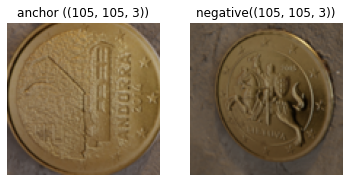

In [12]:
for image in data:
    anchor = image[0].numpy()
    validation = image[1].numpy()
    label = "positive" if (image[2].numpy() == 1) else "negative"

    # show the images
    plt.subplot(1, 2, 1)
    plt.imshow(anchor)
    plt.axis('off')
    plt.title("anchor (" + str(image[0].shape) + ")")
    plt.subplot(1, 2, 2)
    plt.imshow(validation)
    plt.axis('off')
    plt.title(label + "(" + str(image[1].shape) + ")")
    plt.show()

    break

## Build model

In [13]:
from src.models import make_embedding, make_siamese_model

In [14]:
embedding = make_embedding()
siamese_model = make_siamese_model(embedding)

In [15]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

| Layer            | (type)         | Output Shape          | Param  |
| ---------------- | -------------- | --------------------- | ------ |
| input_image      | (InputLayer)   | [(None, 105, 105, 3)] | 0      |
| conv2d_16        | (Conv2D)       | (None, 96, 96, 64)    | 19264  |
| max_pooling2d_12 | (MaxPooling2D) | (None, 48, 48, 64)    | 0      |
| conv2d_17        | (Conv2D)       | (None, 42, 42, 128)   | 401536 |
| max_pooling2d_13 | (MaxPooling2D) | (None, 21, 21, 128)   | 0      |
| conv2d_18        | (Conv2D)       | (None, 18, 18, 128)   | 262272 |
| max_pooling2d_14 | (MaxPooling2D) | (None, 9, 9, 128)     | 0      |
| conv2d_19        | (Conv2D)       | (None, 6, 6, 256)     | 524544 |
| flatten_4        | (Flatten)      | (None, 9216)          | 0      |

- Total params: 38,960,448
- Trainable params: 38,960,448
- Non-trainable params: 0

In [16]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

| Layer          | (type)       | Output Shape          | Param    | Connected to                               |
| -------------- | ------------ | --------------------- | -------- | ------------------------------------------ |
| input_img      | (InputLayer) | [(None, 105, 105, 3)] | 0        | []                                         |
| validation_img | (InputLayer) | [(None, 105, 105, 3)] | 0        | []                                         |
| embedding      | (Functional) | (None, 4096)          | 38960448 | `['input_img[0][0]','validation_img[0][0]']` |
| distance       | (L1Dist)     | (None, 4096)          | 0        | `['embedding[0][0]','embedding[1][0]']`      |
| dense_8        | (Dense)      | (None, 1)             | 4097     | `['distance[0][0]']`                         |

- Total params: 38,964,545
- Trainable params: 38,964,545
- Non-trainable params: 0


In [17]:
data = data.cache()
data = data.shuffle(buffer_size=10000)


# Training partition
# size of one batch
train_data = data.batch(16)

# prefetch data for faster training (prefetching means that the data is
# preprocessed (e.g. batched) while the model is training on the previous batch)
# 8 is the number of batches that will be prepared in advance
train_data = train_data.prefetch(8)

binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)  # 0.0001

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [18]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [ ]:
from random import uniform
import time
from IPython.display import display, clear_output


def black_box():
    i = 1
    for i in range (10):
        print("coucou " + str(i))
        for j in range (10):
            print('Iteration', j, 'Score:', uniform(0, 1), end='')
            time.sleep(0.5)
            print('', end='\r')  # or even print('\r', end='')

# black_box()


In [19]:
from tensorflow.keras.metrics import Precision, Recall
from IPython.display import clear_output

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
            print('', end='\r')

        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 50
train(train_data, EPOCHS)

## Evaluate model

In [ ]:
test_dataset = dataset["test"]

In [ ]:
test_anchor_imgs, test_validation_imgs, test_labels = create_pairs(test_dataset)

In [ ]:
# convert imgs and labels to tensors
test_anchor_imgs = tf.convert_to_tensor(test_anchor_imgs)
test_validation_imgs = tf.convert_to_tensor(test_validation_imgs)
test_labels = tf.convert_to_tensor(test_labels)

In [ ]:
# create a tensorflow dataset
test_data = tf.data.Dataset.from_tensor_slices(
    (test_anchor_imgs, test_validation_imgs, test_labels))

In [ ]:
test_data = test_data.cache()
test_data = test_data.shuffle(buffer_size=10000)
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])

In [ ]:
# Post processing the results
results = np.array([1 if prediction > 0.5 else 0 for prediction in y_hat])

In [ ]:
# compute difference between predicted and true labels
diff = results - np.array(y_true)

# compute accuracy
accuracy = 1 - (np.count_nonzero(diff) / len(diff))
accuracy